In [16]:
import tensorflow
import os
gpu=int(input("Which gpu u want?"))
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu)

Which gpu u want?1


In [17]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = 'Semantic segmentation dataset/'


In [18]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    my_paths=os.listdir(path)
    print(my_paths)
    print(path)
    break
    
   
    dirname = path.split(os.path.sep)[-1]
    print(dirname)
    
    if dirname == 'images':   #Find all 'images' directories
        images = my_paths 
        print(images)
        break

['Tile 5', 'Tile 7', 'Tile 1', 'Tile 2', 'Tile 8', 'Tile 3', 'Tile 4', 'classes.json', 'Tile 6']
Semantic segmentation dataset/


In [19]:
patch_size = 256
mask_dataset = []  
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
image_names=[]
flag=0
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    my_paths=os.listdir(path)
    print(path)
   
    dirname = path.split(os.path.sep)[-1]
    print(dirname)
    
    if dirname == 'images':   #Find all 'images' directories
        flag=1
        images = my_paths  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                
                image_names.append(image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
   
    if dirname == 'masks':
        flag=2
        #Find all 'images' directories
        masks = my_paths #List of all image names in this subdirectory
       
    
      
        for mask_name in image_names:  
            mask_name=mask_name[:-4]+".png"
        
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
    if flag==2:
        flag=0
        image_names=[]

Semantic segmentation dataset/

Semantic segmentation dataset/Tile 5
Tile 5
Semantic segmentation dataset/Tile 5/images
images
Now patchifying image: Semantic segmentation dataset/Tile 5/images/image_part_004.jpg
Now patchifying image: Semantic segmentation dataset/Tile 5/images/image_part_008.jpg
Now patchifying image: Semantic segmentation dataset/Tile 5/images/image_part_006.jpg
Now patchifying image: Semantic segmentation dataset/Tile 5/images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 5/images/image_part_005.jpg
Now patchifying image: Semantic segmentation dataset/Tile 5/images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/Tile 5/images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Tile 5/images/image_part_009.jpg
Now patchifying image: Semantic segmentation dataset/Tile 5/images/image_part_007.jpg
Semantic segmentation dataset/Tile 5/masks
masks
Now patchifying mask: Semantic segmentation datase

Now patchifying mask: Semantic segmentation dataset/Tile 8/masks/image_part_007.png
Semantic segmentation dataset/Tile 3
Tile 3
Semantic segmentation dataset/Tile 3/images
images
Now patchifying image: Semantic segmentation dataset/Tile 3/images/image_part_004.jpg
Now patchifying image: Semantic segmentation dataset/Tile 3/images/image_part_008.jpg
Now patchifying image: Semantic segmentation dataset/Tile 3/images/image_part_006.jpg
Now patchifying image: Semantic segmentation dataset/Tile 3/images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 3/images/image_part_005.jpg
Now patchifying image: Semantic segmentation dataset/Tile 3/images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/Tile 3/images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Tile 3/images/image_part_009.jpg
Now patchifying image: Semantic segmentation dataset/Tile 3/images/image_part_007.jpg
Semantic segmentation dataset/Tile 3/masks
mask

In [20]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

#Sanity check, view few mages

In [21]:
mask_dataset[0]

array([[[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [226, 169,  41],
        [226, 169,  41],
        [226, 169,  41]],

       [[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [226, 169,  41],
        [226, 169,  41],
        [226, 169,  41]],

       [[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [226, 169,  41],
        [226, 169,  41],
        [226, 169,  41]],

       ...,

       [[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [226, 169,  41],
        [226, 169,  41],
        [226, 169,  41]],

       [[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [226, 169,  41],
        [226, 169,  41],
        [226, 169,  41]],

       [[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [226, 169,  41],
        [226, 169,  41],
        [226, 169,  41]]

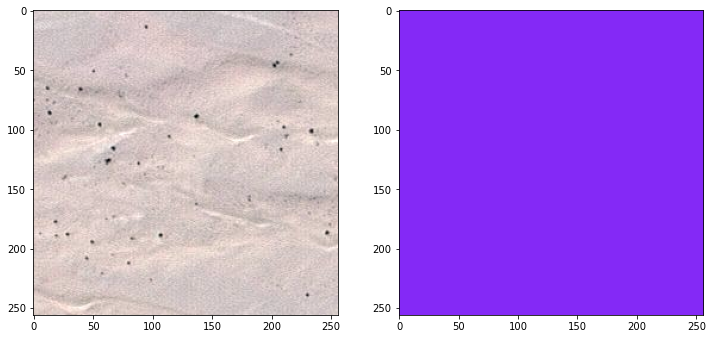

In [22]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()


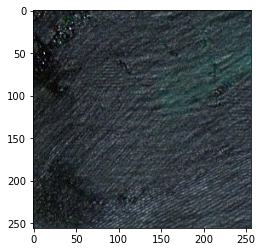

In [23]:
plt.imshow(image_dataset[1])

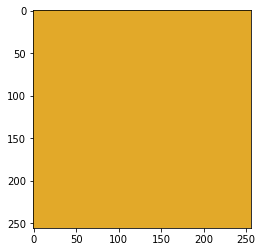

In [24]:
plt.imshow(mask_dataset[1])

In [25]:
###########################################################################
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F
Example: RGB --> R=201, G=, B=
R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)
Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152
"""
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

60


In [26]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg


In [27]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

In [28]:
labels[0].shape

(256, 256, 1)

Unique labels in label dataset are:  [0 1 2 3 4 5]


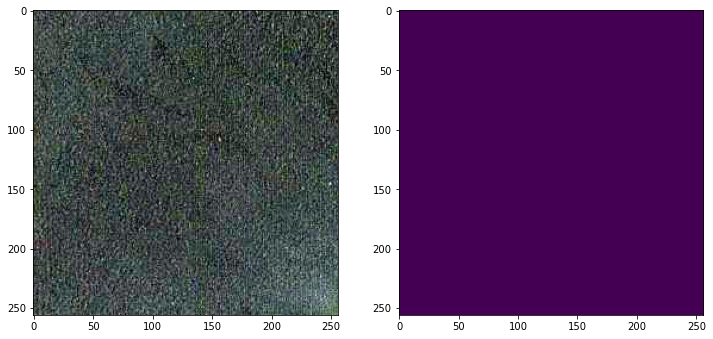

In [29]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [30]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)



In [31]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
from tensorflow.keras import backend as K 
smooth = 1


def iou_score(y_pred, y_true, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    iou = (intersection + smooth)/(union + smooth)
    return iou

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('attention_resunet_model.hdf5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score})

2022-12-21 23:38:24.662894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 23:38:25.087465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38413 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [20]:
#x=test_image_dataset[100].reshape(1,256,256,1)
pred=model1.predict(X_test)

9/9 [==============================] - 1s 127ms/step


In [21]:
#by combing all into 256 x 256

y_pred_thresholded=pred>0.5
intersection=np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
iou_score=np.sum(intersection)/np.sum(union)
print(iou_score)

0.7842000377558059


In [23]:
import tensorflow as tf
def dice_coefficient(y_true,y_pred,smooth=1):
    intersection=K.sum(y_true*y_pred,axis=[1,2,3])
    y=K.sum(y_true,axis=[1,2,3])
    
    x=K.sum(y_pred,axis=[1,2,3])
    
    union=x+y
    return K.mean((2*intersection*smooth)/(union*smooth),axis=0)
dice_score=dice_coefficient(y_test,pred,smooth=1)
    

In [24]:
dice_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.63499564>

In [53]:
from tensorflow.keras.models import load_model
model1 = load_model('attention_unet_model.hdf5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score})

In [21]:
#x=test_image_dataset[100].reshape(1,256,256,1)
pred=model1.predict(X_test)

9/9 [==============================] - 1s 89ms/step


In [22]:
y_pred_thresholded=pred>0.5
intersection=np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
iou_score=np.sum(intersection)/np.sum(union)
print(iou_score)

0.7999941653047524


In [23]:
import tensorflow as tf
def dice_coefficient(y_true,y_pred,smooth=1):
    intersection=K.sum(y_true*y_pred,axis=[1,2,3])
    y=K.sum(y_true,axis=[1,2,3])
    
    x=K.sum(y_pred,axis=[1,2,3])
    
    union=x+y
    return K.mean((2*intersection*smooth)/(union*smooth),axis=0)
dice_score=dice_coefficient(y_test,pred,smooth=1)
    

In [24]:
dice_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.8869617>

In [55]:
from tensorflow.keras.models import load_model
model1 = load_model('unet_model.hdf5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score})

In [26]:
#x=test_image_dataset[100].reshape(1,256,256,1)
pred=model1.predict(X_test)

9/9 [==============================] - 2s 103ms/step


In [27]:
y_pred_thresholded=pred>0.5
intersection=np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
iou_score=np.sum(intersection)/np.sum(union)
print(iou_score)

0.8028767392909175


In [28]:
import tensorflow as tf
def dice_coefficient(y_true,y_pred,smooth=1):
    intersection=K.sum(y_true*y_pred,axis=[1,2,3])
    y=K.sum(y_true,axis=[1,2,3])
    
    x=K.sum(y_pred,axis=[1,2,3])
    
    union=x+y
    return K.mean((2*intersection*smooth)/(union*smooth),axis=0)
dice_score=dice_coefficient(y_test,pred,smooth=1)
    

In [29]:
dice_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.88937867>

In [103]:
from tensorflow.keras.models import load_model
model1 = load_model('attention_resunet_model.hdf5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score})

1/1 [==============================] - 0s 42ms/step


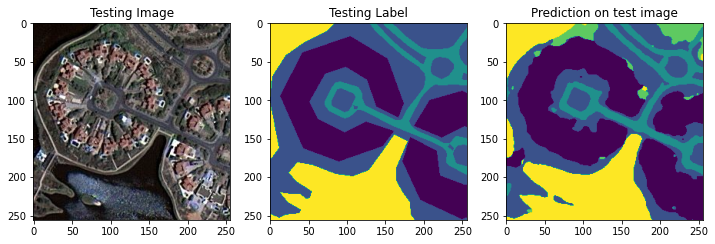

In [104]:
import matplotlib.pyplot as plt
import random
y_pred=model1.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)
test_img_number = 4
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model1.predict(test_img_input))
predicted_img1=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img1)
plt.show()

In [92]:
predicted_img1

array([[4, 4, 4, ..., 3, 3, 3],
       [4, 4, 4, ..., 3, 3, 3],
       [4, 4, 4, ..., 3, 3, 3],
       ...,
       [4, 4, 4, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0]])

In [93]:
from tensorflow.keras.models import load_model
model1 = load_model('unet_model.hdf5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score})

1/1 [==============================] - 0s 44ms/step


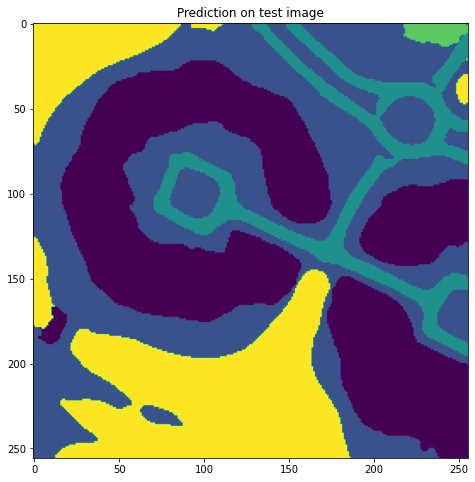

In [94]:
import matplotlib.pyplot as plt
import random
y_pred=model1.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)
test_img_number = 4
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model1.predict(test_img_input))
predicted_img2=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))

plt.title('Prediction on test image')
plt.imshow(predicted_img2)
plt.show()

In [33]:
from tensorflow.keras.models import load_model
model1 = load_model('attention_unet_model.hdf5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score})

2022-12-21 23:58:14.388606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 23:58:14.785259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38411 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


1/1 [==============================] - 0s 38ms/step


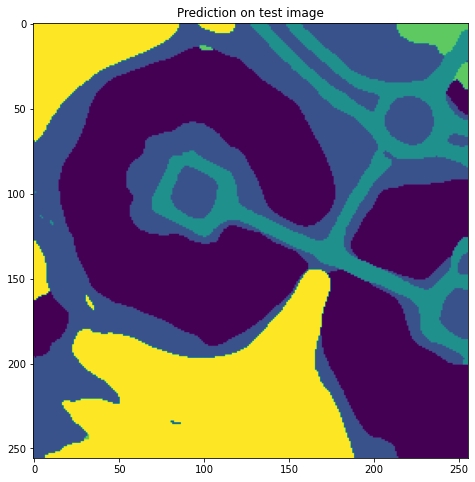

In [96]:
import matplotlib.pyplot as plt
import random
y_pred=model1.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)
test_img_number = 4
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model1.predict(test_img_input))
predicted_img3=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))

plt.title('Prediction on test image')
plt.imshow(predicted_img3)
plt.show()

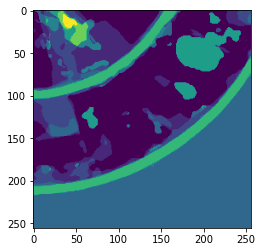

In [57]:
plt.imshow(predicted_img1+predicted_img2+predicted_img3)

In [78]:
predicted_img1.shape

(256, 256)

In [79]:
predicted_img2.shape

(256, 256)

In [80]:
predicted_img.shape

(256, 256)

In [81]:
predicted_img

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [97]:
new = np.zeros((256,256))


In [98]:
ground_truth

array([[4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       ...,
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1]])

In [99]:
for i in range(256):
    for j in range(256):
        if ground_truth[i][j]==predicted_img2[i][j]:
            new[i][j]=predicted_img2[i][j]
        elif ground_truth[i][j]==predicted_img1[i][j]:
            new[i][j]=predicted_img1[i][j]
        elif ground_truth[i][j]==predicted_img3[i][j]:
            new[i][j]=predicted_img3[i][j]
        
            
            

In [100]:
new

array([[4., 4., 4., ..., 0., 0., 1.],
       [4., 4., 4., ..., 0., 0., 0.],
       [4., 4., 4., ..., 0., 0., 0.],
       ...,
       [4., 4., 4., ..., 0., 0., 0.],
       [4., 4., 4., ..., 0., 0., 0.],
       [4., 4., 4., ..., 0., 0., 0.]])

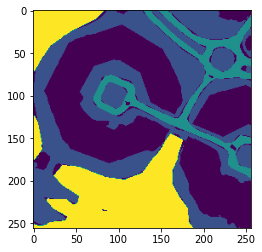

In [101]:
plt.imshow(new)

In [34]:
model1 = load_model('attention_resunet_model.hdf5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score})
model2 = load_model('unet_model.hdf5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score})
model3 = load_model('attention_unet_model.hdf5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score}) 
ans=[]
true=[]

from tqdm import tqdm
for index in tqdm(range(len(X_test))):
    
    test_img = X_test[index]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model1.predict(test_img_input))
    predicted_img1=np.argmax(prediction, axis=3)[0,:,:]
    
    test_img = X_test[index]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model2.predict(test_img_input))
    predicted_img2=np.argmax(prediction, axis=3)[0,:,:]
    
    test_img = X_test[index]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model3.predict(test_img_input))
    predicted_img3=np.argmax(prediction, axis=3)[0,:,:]
    
    y_test_argmax=np.argmax(y_test, axis=3)
    ground_truth=y_test_argmax[index]
    true.append(ground_truth)
    new = np.zeros((256,256))
    for i in range(256):
        for j in range(256):
            if ground_truth[i][j]==predicted_img2[i][j]:
                new[i][j]=predicted_img2[i][j]
            elif ground_truth[i][j]==predicted_img1[i][j]:
                new[i][j]=predicted_img1[i][j]
            elif ground_truth[i][j]==predicted_img3[i][j]:
                new[i][j]=predicted_img3[i][j]
    ans.append(new)
ans=np.array(ans)
    
    
    
    
    

  0%|          | 0/261 [00:00<?, ?it/s]2022-12-21 23:58:23.561025: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-21 23:58:24.195780: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-21 23:58:24.199291: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2022-12-21 23:58:24.199396: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-12-21 23:58:24.199705: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customiz

1/1 [==============================] - 0s 368ms/step


  0%|          | 1/261 [00:04<19:02,  4.39s/it]

1/1 [==============================] - 0s 37ms/step


  1%|          | 2/261 [00:04<09:02,  2.09s/it]

1/1 [==============================] - 0s 36ms/step


  1%|          | 3/261 [00:05<05:53,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 4/261 [00:05<04:22,  1.02s/it]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 5/261 [00:06<03:31,  1.21it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 6/261 [00:06<02:59,  1.42it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 7/261 [00:07<02:38,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 8/261 [00:07<02:25,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 9/261 [00:08<02:16,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 10/261 [00:08<02:10,  1.92it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 11/261 [00:09<02:05,  1.99it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 12/261 [00:09<02:02,  2.03it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 13/261 [00:10<01:59,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 14/261 [00:10<01:58,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 15/261 [00:11<01:57,  2.09it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 16/261 [00:11<02:08,  1.91it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 17/261 [00:12<02:03,  1.97it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 18/261 [00:12<02:02,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 19/261 [00:13<02:00,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 20/261 [00:13<01:58,  2.03it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 21/261 [00:14<01:57,  2.05it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 22/261 [00:14<01:56,  2.06it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 23/261 [00:15<01:55,  2.06it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 24/261 [00:15<01:53,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 25/261 [00:15<01:52,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 26/261 [00:16<01:52,  2.10it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 27/261 [00:16<01:50,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 28/261 [00:17<01:51,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 29/261 [00:17<01:50,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 30/261 [00:18<01:49,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 31/261 [00:18<01:48,  2.12it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 32/261 [00:19<01:48,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 33/261 [00:19<01:47,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 34/261 [00:20<01:47,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 35/261 [00:20<01:47,  2.10it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 36/261 [00:21<01:47,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 37/261 [00:21<01:45,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 38/261 [00:22<01:44,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 39/261 [00:22<01:44,  2.13it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 40/261 [00:23<01:44,  2.12it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 41/261 [00:23<01:45,  2.09it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 42/261 [00:24<01:45,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 43/261 [00:24<01:43,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 44/261 [00:24<01:42,  2.12it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 45/261 [00:25<01:41,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 46/261 [00:25<01:40,  2.13it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 47/261 [00:26<01:39,  2.14it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 48/261 [00:26<01:39,  2.15it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 49/261 [00:27<01:38,  2.15it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 50/261 [00:27<01:37,  2.16it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 51/261 [00:28<01:38,  2.14it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 52/261 [00:28<01:37,  2.14it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 53/261 [00:29<01:38,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 54/261 [00:29<01:37,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 55/261 [00:30<01:37,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 56/261 [00:30<01:36,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 57/261 [00:31<01:36,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 58/261 [00:31<01:36,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 59/261 [00:31<01:35,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 60/261 [00:32<01:34,  2.12it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 61/261 [00:32<01:34,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 62/261 [00:33<01:34,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 63/261 [00:33<01:33,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 64/261 [00:34<01:33,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 65/261 [00:34<01:33,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 66/261 [00:35<01:32,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 67/261 [00:35<01:31,  2.12it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 68/261 [00:36<01:32,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 69/261 [00:36<01:31,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 70/261 [00:37<01:29,  2.14it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 71/261 [00:37<01:29,  2.12it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 72/261 [00:38<01:29,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 73/261 [00:38<01:29,  2.11it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 74/261 [00:39<01:28,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 75/261 [00:39<01:27,  2.12it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 76/261 [00:40<01:26,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 77/261 [00:40<01:26,  2.12it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 78/261 [00:40<01:26,  2.12it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 79/261 [00:41<01:25,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 80/261 [00:41<01:25,  2.12it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 81/261 [00:42<01:24,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 82/261 [00:42<01:23,  2.15it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 83/261 [00:43<01:23,  2.14it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 84/261 [00:43<01:22,  2.15it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 85/261 [00:44<01:22,  2.14it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 86/261 [00:44<01:23,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 87/261 [00:45<01:21,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 88/261 [00:45<01:22,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 89/261 [00:46<01:21,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 90/261 [00:46<01:20,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 91/261 [00:47<01:20,  2.12it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 92/261 [00:47<01:20,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 93/261 [00:48<01:19,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 94/261 [00:48<01:19,  2.10it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 95/261 [00:49<01:19,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 96/261 [00:49<01:18,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 97/261 [00:49<01:16,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 98/261 [00:50<01:17,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 99/261 [00:50<01:16,  2.13it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 100/261 [00:51<01:15,  2.12it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 101/261 [00:51<01:15,  2.13it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 102/261 [00:52<01:15,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 103/261 [00:52<01:14,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 104/261 [00:53<01:13,  2.12it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 105/261 [00:53<01:12,  2.14it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 106/261 [00:54<01:11,  2.17it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 107/261 [00:54<01:10,  2.18it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 108/261 [00:55<01:10,  2.19it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 109/261 [00:55<01:09,  2.20it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 110/261 [00:55<01:08,  2.20it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 111/261 [00:56<01:09,  2.15it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 112/261 [00:56<01:10,  2.12it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 113/261 [00:57<01:10,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 114/261 [00:57<01:10,  2.09it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 115/261 [00:58<01:10,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 116/261 [00:58<01:09,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 117/261 [00:59<01:08,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 118/261 [00:59<01:08,  2.10it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 119/261 [01:00<01:07,  2.09it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 120/261 [01:00<01:07,  2.09it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 121/261 [01:01<01:06,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 122/261 [01:01<01:06,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 123/261 [01:02<01:06,  2.09it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 124/261 [01:02<01:05,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 125/261 [01:03<01:05,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 126/261 [01:03<01:04,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 127/261 [01:04<01:03,  2.09it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 128/261 [01:04<01:03,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 129/261 [01:05<01:02,  2.12it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 130/261 [01:05<01:01,  2.12it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 131/261 [01:05<01:01,  2.12it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 132/261 [01:06<01:00,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 133/261 [01:06<00:59,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 134/261 [01:07<00:59,  2.14it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 135/261 [01:07<01:00,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 136/261 [01:08<00:59,  2.10it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 137/261 [01:08<00:58,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 138/261 [01:09<00:58,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 139/261 [01:09<00:57,  2.13it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 140/261 [01:10<00:56,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 141/261 [01:10<00:56,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 142/261 [01:11<00:56,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 143/261 [01:11<00:55,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 144/261 [01:12<00:54,  2.14it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 145/261 [01:12<00:54,  2.12it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 146/261 [01:13<00:54,  2.11it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 147/261 [01:13<00:54,  2.10it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 148/261 [01:14<00:54,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 149/261 [01:14<00:53,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 150/261 [01:14<00:52,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 151/261 [01:15<00:52,  2.09it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 152/261 [01:15<00:52,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 153/261 [01:16<00:51,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 154/261 [01:16<00:51,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 155/261 [01:17<00:50,  2.10it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 156/261 [01:17<00:49,  2.12it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 157/261 [01:18<00:49,  2.12it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 158/261 [01:18<00:48,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 159/261 [01:19<00:48,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 160/261 [01:19<00:48,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 161/261 [01:20<00:47,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 162/261 [01:20<00:47,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 163/261 [01:21<00:46,  2.10it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 164/261 [01:21<00:45,  2.12it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 165/261 [01:22<00:45,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 166/261 [01:22<00:44,  2.12it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 167/261 [01:23<00:44,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 168/261 [01:23<00:43,  2.13it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 169/261 [01:23<00:43,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 170/261 [01:24<00:42,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 171/261 [01:24<00:42,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 172/261 [01:25<00:41,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 173/261 [01:25<00:41,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 174/261 [01:26<00:40,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 175/261 [01:26<00:40,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 176/261 [01:27<00:39,  2.13it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 177/261 [01:27<00:39,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 178/261 [01:28<00:39,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 179/261 [01:28<00:38,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 180/261 [01:29<00:37,  2.13it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 181/261 [01:29<00:37,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 182/261 [01:30<00:37,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 183/261 [01:30<00:36,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 184/261 [01:31<00:35,  2.14it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 185/261 [01:31<00:35,  2.14it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 186/261 [01:31<00:35,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 187/261 [01:32<00:34,  2.15it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 188/261 [01:32<00:34,  2.14it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 189/261 [01:33<00:33,  2.14it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 190/261 [01:33<00:33,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 191/261 [01:34<00:33,  2.10it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 192/261 [01:34<00:32,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 193/261 [01:35<00:32,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 194/261 [01:35<00:31,  2.13it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 195/261 [01:36<00:31,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 196/261 [01:36<00:30,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 197/261 [01:37<00:30,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 198/261 [01:37<00:29,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 199/261 [01:38<00:29,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 200/261 [01:38<00:28,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 201/261 [01:39<00:28,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 202/261 [01:39<00:27,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 203/261 [01:40<00:27,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 204/261 [01:40<00:26,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 205/261 [01:40<00:26,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 206/261 [01:41<00:25,  2.14it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 207/261 [01:41<00:25,  2.14it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 208/261 [01:42<00:24,  2.14it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 209/261 [01:42<00:24,  2.14it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 210/261 [01:43<00:23,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 211/261 [01:43<00:23,  2.14it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 212/261 [01:44<00:22,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 213/261 [01:44<00:22,  2.14it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 214/261 [01:45<00:22,  2.14it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 215/261 [01:45<00:21,  2.14it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 216/261 [01:46<00:20,  2.15it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 217/261 [01:46<00:20,  2.15it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 218/261 [01:47<00:19,  2.18it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 219/261 [01:47<00:19,  2.17it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 220/261 [01:47<00:19,  2.15it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 221/261 [01:48<00:18,  2.12it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 222/261 [01:48<00:18,  2.09it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 223/261 [01:49<00:18,  2.08it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 224/261 [01:49<00:17,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 225/261 [01:50<00:17,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 226/261 [01:50<00:16,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 227/261 [01:51<00:16,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 228/261 [01:51<00:15,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 229/261 [01:52<00:15,  2.10it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 230/261 [01:52<00:14,  2.11it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▊ | 231/261 [01:53<00:14,  2.09it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 232/261 [01:53<00:13,  2.11it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 233/261 [01:54<00:13,  2.11it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 234/261 [01:54<00:12,  2.11it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 235/261 [01:55<00:12,  2.11it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 236/261 [01:55<00:12,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 237/261 [01:56<00:11,  2.07it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 238/261 [01:56<00:11,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 239/261 [01:57<00:10,  2.11it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 240/261 [01:57<00:10,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 241/261 [01:58<00:09,  2.07it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 242/261 [01:58<00:09,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 243/261 [01:58<00:08,  2.09it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 244/261 [01:59<00:08,  2.11it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 245/261 [01:59<00:07,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 246/261 [02:00<00:07,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 247/261 [02:00<00:06,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 248/261 [02:01<00:06,  2.12it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 249/261 [02:01<00:05,  2.10it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 250/261 [02:02<00:05,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 251/261 [02:02<00:04,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 252/261 [02:03<00:04,  2.10it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 253/261 [02:03<00:03,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 254/261 [02:04<00:03,  2.08it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 255/261 [02:04<00:02,  2.09it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 256/261 [02:05<00:02,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 257/261 [02:05<00:01,  2.09it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 258/261 [02:06<00:01,  2.10it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 259/261 [02:06<00:00,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 260/261 [02:07<00:00,  2.10it/s]

1/1 [==============================] - 0s 40ms/step


100%|██████████| 261/261 [02:07<00:00,  2.05it/s]


In [35]:
ans.shape

(261, 256, 256)

In [36]:
ans = np.expand_dims(ans, axis=3)
n_classes = len(np.unique(ans))
from tensorflow.keras.utils import to_categorical
ans_cat = to_categorical(ans, num_classes=n_classes)

In [38]:
ans_cat.shape

(261, 256, 256, 6)

In [39]:
y_test.shape

(261, 256, 256, 6)

In [122]:
y_test_argmax=np.argmax(y_test, axis=3)
y_test_argmax.shape

(261, 256, 256)

In [40]:
y_pred_thresholded=ans_cat>0.5
intersection=np.logical_and(y_test,ans_cat)
union=np.logical_or(y_test,ans_cat)
iou_score=np.sum(intersection)/np.sum(union)
print(iou_score)

0.8951336041306076


In [1]:
import tensorflow as tf
def dice_coefficient(y_true,y_pred,smooth=1):
    intersection=K.sum(y_true*y_pred,axis=-1)
    y=K.sum(y_true,axis=-1)
    
    x=K.sum(y_pred,axis=-1)
    
    union=x+y
    return K.mean((2*intersection*smooth)/(union*smooth),axis=0)
dice_score=dice_coefficient(y_test,ans_cat,smooth=1)
dice_score

NameError: name 'y_test' is not defined

In [42]:
def my_dice(img1,img2):
 intersection = np.logical_and(img1, img2)
 union = np.logical_or(img1, img2)
 dice = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection))
 return dice
my_dice(y_test,ans_cat)

0.9446654338032806